# COMP5318 - Machine Learning and Data Mining 

## Assignment 2

#### Tuning parameters for DT and RF

### 1 Load Data 

In [4]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

### 2 Preprocessing

#### 2.1 Entropy principle

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


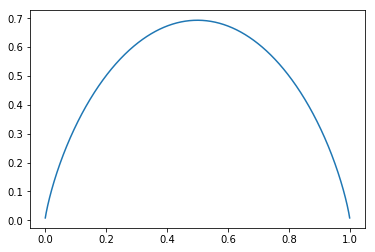

In [8]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 1, 0.001)
y = -x*np.log(x) - (1-x) * np.log(1-x) # entropy
plt.plot(x, y)
plt.show()

#### 2.2 Gini principle

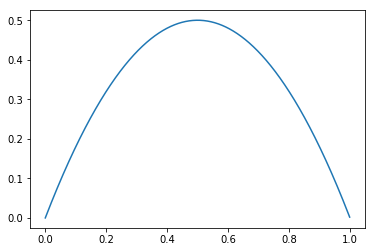

In [9]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 1, 0.001)
y2 = 1 - x**2 - (1-x)**2 # gini
plt.plot(x, y2)
plt.show()
# entropy is slower than gini, sklearn default choice is gini

### 2.3 StandardScaler

In [7]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
standardScaler.fit(X_train)

G:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [127]:
X_train_standard = standardScaler.transform(X_train)
X_test_standard = standardScaler.transform(X_test)

C:\Users\Charl\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 2.4 PCA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(0.9)
pca.fit(X_train_standard)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

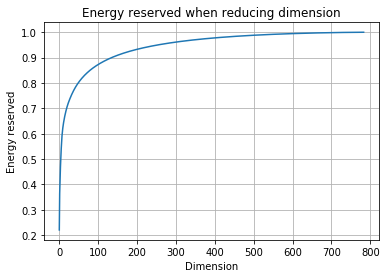

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([i for i in range(X_train_standard.shape[1])], [np.sum(pca.explained_variance_ratio_[:i+1]) \
                                                         for i in range(X_train_standard.shape[1])])
plt.grid()
plt.title('Energy reserved when reducing dimension')
plt.xlabel('Dimension')
plt.ylabel('Energy reserved')
plt.show()

#### This means that 136-dimension can keep 90% information

In [9]:
X_train_pca = pca.transform(X_train_standard)
X_test_pca = pca.transform(X_test_standard)

In [10]:
print('shape of X_train:', X_train_pca.shape)

shape of X_train: (48000, 136)


### 3 Decision tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=666)

#### 3.1 Tune parameters

#### 3.1.1 PCA data:

In [44]:
from sklearn.model_selection import GridSearchCV
if __name__=='__main__':
    param_grid = [
        {
            'criterion': ['gini', 'entropy'],
            'max_depth': [10, 15, 20, 50, 75, 100],
            'splitter': ['best', 'random']
        }
    ]
    grid_search_pca = GridSearchCV(dt_clf, param_grid, n_jobs=-1, verbose=2)
    grid_search_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.5min finished


In [13]:
grid_search_pca.best_score_

0.77825

In [14]:
grid_search_pca.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'splitter': 'best'}

In [15]:
best_dt_clf_pca = grid_search_pca.best_estimator_
best_dt_clf_pca.score(X_test_pca, y_test)

0.7795

####  3.1.2 Raw data without PCA or standardization:

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 15, 20, 50, 75, 100],
        'splitter': ['best', 'random']
    }
]
grid_search = GridSearchCV(dt_clf, param_grid, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20, 50, 75, 100], 'splitter': ['best', 'random']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [17]:
grid_search.best_score_

0.8072291666666667

In [18]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}

In [19]:
best_dt_clf = grid_search.best_estimator_
best_dt_clf.score(X_test, y_test)

0.8018

#### 3.1.3 Standardization data(best):

In [200]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 15, 20, 50, 75, 100],
        'splitter': ['best', 'random']
    }
]
grid_search = GridSearchCV(dt_clf, param_grid, n_jobs=-1, verbose=2)
grid_search.fit(X_train_standard, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20, 50, 75, 100], 'splitter': ['best', 'random']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [211]:
dt_ranks = np.argsort(-grid_search.cv_results_['mean_test_score'])
dt_ranks

array([12,  0,  2, 14,  3, 13,  4, 15, 16, 22, 20, 18,  5,  1, 17,  8,  6,
       10, 21, 23, 19,  9,  7, 11], dtype=int64)

In [205]:
dt_params = grid_search.cv_results_['params']
dt_scores = grid_search.cv_results_['mean_test_score']

In [213]:
dt_indexes = dt_ranks[:]
[dt_params[i] for i in dt_indexes]

[{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'},
 {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'},
 {'criterion': 'gini', 'max_depth': 15, 'splitter': 'best'},
 {'criterion': 'entropy', 'max_depth': 15, 'splitter': 'best'},
 {'criterion': 'gini', 'max_depth': 15, 'splitter': 'random'},
 {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'},
 {'criterion': 'gini', 'max_depth': 20, 'splitter': 'best'},
 {'criterion': 'entropy', 'max_depth': 15, 'splitter': 'random'},
 {'criterion': 'entropy', 'max_depth': 20, 'splitter': 'best'},
 {'criterion': 'entropy', 'max_depth': 100, 'splitter': 'best'},
 {'criterion': 'entropy', 'max_depth': 75, 'splitter': 'best'},
 {'criterion': 'entropy', 'max_depth': 50, 'splitter': 'best'},
 {'criterion': 'gini', 'max_depth': 20, 'splitter': 'random'},
 {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'},
 {'criterion': 'entropy', 'max_depth': 20, 'splitter': 'random'},
 {'criterion': 'gini', 'max_depth': 75, 'spli

In [214]:
dt_scores[dt_indexes]

array([0.8071875 , 0.80622917, 0.8035    , 0.80025   , 0.7968125 ,
       0.796375  , 0.79608333, 0.79558333, 0.79410417, 0.79247917,
       0.79247917, 0.79247917, 0.7905    , 0.7905    , 0.78785417,
       0.78733333, 0.78733333, 0.78733333, 0.78677083, 0.78677083,
       0.78677083, 0.78302083, 0.78302083, 0.78302083])

In [203]:
grid_search.best_score_

0.8071875

In [204]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}

In [62]:
best_dt_clf = grid_search.best_estimator_
best_dt_clf.score(X_test_standard, y_test)

0.8018

#### DecisionTree depends too much on some certain data

### 4 RandomForest

#### 4.1.1 PCA data:

In [99]:
# Random Forest donot need validation because of internal OOB data

import numpy as np
X_train_pca_all = np.vstack([X_train_pca, X_val_pca])
y_train_pca_all = np.hstack([y_train, y_val])
print(X_train_pca_all.shape)
print(y_train_pca_all.shape) # all pca data

(60000, 136)
(60000,)


In [92]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=666)

C:\Users\Charl\Anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [100]:
param_grid = [
    {
        'criterion' : ['entropy', 'gini'],
        'n_estimators' : [ 30, 50, 75, 100, 120, 140],
        'max_depth' : [20, 25, 30, 35, 50]
    }
]
grid_search_rf = GridSearchCV(rf_clf, param_grid, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_pca_all, y_train_pca_all)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 138.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 151.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=666, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['entropy', 'gini'], 'n_estimators': [30, 50, 75, 100, 120, 140], 'max_depth': [20, 25, 30, 35, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [102]:
grid_search_rf.best_score_

0.867

In [103]:
grid_search_rf.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 140}

In [104]:
best_rf_clf_pca = grid_search_rf.best_estimator_
best_rf_clf_pca.score(X_test_pca, y_test)

0.8606

####  4.1.2 Raw data without PCA or standardization:

In [283]:
import numpy as np
X_train_all = np.vstack([X_train, X_val])
y_train_all = np.hstack([y_train, y_val])
print(X_train_all.shape)
print(y_train_all.shape) # all raw data

(60000, 784)
(60000,)


In [284]:
param_grid = [
    {
        'criterion' : ['entropy', 'gini'],
        'n_estimators' : [10, 30, 50, 75, 100, 120, 140],
        'max_depth' : [20, 25, 30, 35, 50]
    }
]
grid_search_rf = GridSearchCV(rf_clf, param_grid, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_all, y_train_all)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 65.7min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed: 153.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=666, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['entropy', 'gini'], 'n_estimators': [10, 30, 50, 75, 100, 120, 140], 'max_depth': [10, 30, 50, 75, 100, 120, 140]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [285]:
grid_search_rf.best_score_

0.8812833333333333

In [286]:
grid_search_rf.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 140}

In [287]:
best_rf_clf = grid_search_rf.best_estimator_
best_rf_clf.score(X_test, y_test)

0.8762

#### best test score of RandomForest:87.81%  
Best test score for now is 87.81% with oob(val) score of 88.23% with  
criterion = centropy
n_estimators=30  
max_depth=120  

#### 3.1.3 Standardization data(best):

In [132]:
import numpy as np
X_train_standard_all = np.vstack([X_train_standard, X_val_standard])
y_train_standard_all = np.hstack([y_train, y_val])
print(X_train_standard_all.shape)
print(y_train_standard_all.shape) # all standard data

(60000, 784)
(60000,)


In [155]:
param_grid = [
    {
        'criterion' : ['entropy', 'gini'],
        'n_estimators' : [30, 50, 75, 100, 120, 140],
        'max_depth' : [20, 25, 30, 35, 50, 75]
    }
]
grid_search_rf = GridSearchCV(rf_clf, param_grid, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_standard_all, y_train_standard_all)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 73.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 118.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=666, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['entropy', 'gini'], 'n_estimators': [30, 50, 75, 100, 120, 140], 'max_depth': [20, 25, 30, 35, 50, 75]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [138]:
grid_search_rf.cv_results_

C:\Users\Charl\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Charl\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Charl\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Charl\A

{'mean_fit_time': array([ 71.08581217, 115.3439734 , 167.1719776 , 220.8428522 ,
        263.54712367, 313.30008419,  70.23847151, 115.53528285,
        175.85090089, 230.83803272, 274.91305105, 322.55631558,
         72.04131683, 116.95957049, 170.75279085, 229.55533918,
        256.63298861, 253.61680222,  56.18001803,  96.995284  ,
        142.39261222, 220.61106531, 277.05204423, 325.29266667,
         70.68001835, 117.03261789, 171.86714451, 210.88888089,
        215.11977442, 233.28036785,  36.66197999,  65.56376791,
         98.69457603, 129.64574305, 154.99064199, 173.86116425,
         38.68026702,  64.41046476, 105.82645194, 136.35956009,
        156.58688315, 182.44624448,  41.42769861,  74.01372131,
        106.53809031, 127.79810214, 155.20925148, 186.1566325 ,
         43.01269976,  75.93899941, 111.29343907, 139.65340479,
        165.88631042, 197.20552047,  45.18434   ,  69.95279217,
         89.41345843, 112.82428273, 137.89531493, 129.03769732]),
 'std_fit_time': arra

In [156]:
grid_search_rf.best_score_

0.8812666666666666

In [157]:
grid_search_rf.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 140}

In [158]:
best_rf_clf = grid_search_rf.best_estimator_

In [159]:
best_rf_clf.score(X_test_standard, y_test)

0.8763

In [220]:
rf_params = grid_search_rf.cv_results_['params']
rf_scores = grid_search_rf.cv_results_['mean_test_score']
rf_ranks = np.argsort(-grid_search_rf.cv_results_['mean_test_score'])
rf_ranks

array([17, 16, 11, 10, 35, 29, 23, 34,  5, 28, 22, 58,  9, 15, 53, 59, 71,
       65, 33,  3, 21, 64, 27,  4, 70, 52, 47, 46,  8, 51, 14, 57, 69, 63,
       32, 20, 26, 40, 41,  2, 45, 50, 39, 44,  1, 68, 62, 56, 38, 13, 25,
        7, 19, 31, 43, 61, 67, 49,  0, 55, 37, 24, 18, 30, 12, 42,  6, 54,
       48, 36, 66, 60], dtype=int64)

In [227]:
indexes = rf_ranks[:14]

In [228]:
[rf_params[i] for i in indexes]

[{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 140},
 {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 120},
 {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 140},
 {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 120},
 {'criterion': 'entropy', 'max_depth': 75, 'n_estimators': 140},
 {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 140},
 {'criterion': 'entropy', 'max_depth': 35, 'n_estimators': 140},
 {'criterion': 'entropy', 'max_depth': 75, 'n_estimators': 120},
 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 140},
 {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 120},
 {'criterion': 'entropy', 'max_depth': 35, 'n_estimators': 120},
 {'criterion': 'gini', 'max_depth': 35, 'n_estimators': 120},
 {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 100},
 {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}]

In [229]:
rf_scores[indexes]

array([0.88126667, 0.88125   , 0.88111667, 0.88106667, 0.88105   ,
       0.88105   , 0.88105   , 0.88091667, 0.88091667, 0.88091667,
       0.88091667, 0.88088333, 0.88073333, 0.88073333])